In [1]:
'''Problem statement :  Design a system that predicts the fare amount for a cab ride in the city.
According to CRISP DM Process this problem statement lies in the category of forecasting which deals with
predicting continuous value for future(in our case the continuous value is the fare amount of the cab ride.)'''

'Problem statement :  Design a system that predicts the fare amount for a cab ride in the city.\nAccording to CRISP DM Process this problem statement lies in the category of forecasting which deals with\npredicting continuous value for future(in our case the continuous value is the fare amount of the cab ride.)'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import KNN
import datetime
import itertools
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from math import sqrt
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from IPython import get_ipython

Using TensorFlow backend.


In [3]:
cab_df=pd.read_csv("train_cab.csv")
cab_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [4]:
cab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.7+ KB


In [5]:
'''Data Type conversion : So that pickup_datetime and fare_amount get converted to proper datatypes.'''

'Data Type conversion : So that pickup_datetime and fare_amount get converted to proper datatypes.'

In [6]:
cab_df['fare_amount']=pd.to_numeric(cab_df['fare_amount'],errors='coerce')

In [7]:
cab_df['pickup_datetime']=pd.to_datetime(cab_df['pickup_datetime'],errors='coerce')

In [8]:
cab_df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
dtype: object

In [9]:
cab_df[(cab_df['pickup_datetime'].isna()==True)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1327,11.5,NaT,-73.981947,40.7282,-73.988582,40.759202,1.0


In [10]:
#As there is only 1 inappropriate format of datetime so deleting it
cab_df = cab_df[cab_df.pickup_datetime.notnull()] 

In [11]:
missing_val=pd.DataFrame(cab_df.isnull().sum())
missing_val=missing_val.reset_index()
missing_val

,index,0
0,fare_amount,25
1,pickup_datetime,0
2,pickup_longitude,0
3,pickup_latitude,0
4,dropoff_longitude,0
5,dropoff_latitude,0
6,passenger_count,55


In [12]:
missing_val=missing_val.rename(columns={'index':'variables',0:'missing_percentage'})
missing_val['missing_percentage']=(missing_val['missing_percentage']/len(cab_df))*100
missing_val=missing_val.sort_values(by='missing_percentage',ascending=False).reset_index(drop=True)
missing_val

,variables,missing_percentage
0,passenger_count,0.342338
1,fare_amount,0.155608
2,pickup_datetime,0.000000
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


In [13]:
cab_df[(cab_df['fare_amount'].isna()==True)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
8,NaN,2012-12-03 13:10:00+00:00,-74.006462,40.726713,-73.993078,40.731628,1.0
26,NaN,2011-02-07 20:01:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0
69,NaN,2015-05-12 23:51:42+00:00,-73.954796,40.779335,-73.944931,40.780087,1.0
126,NaN,2013-09-17 04:22:00+00:00,-73.987210,40.729325,-73.931985,40.697207,1.0
168,NaN,2009-01-16 21:10:00+00:00,-73.994143,40.751193,-73.988897,40.759742,1.0
240,NaN,2009-06-20 19:28:37+00:00,-73.979345,40.776630,-73.973842,40.757074,1.0
305,NaN,2014-07-11 05:07:00+00:00,-73.951660,40.772657,-74.010583,40.721405,2.0
350,NaN,2014-09-05 15:23:00+00:00,-73.968260,40.765140,-73.961115,40.774882,6.0
413,NaN,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,55.0
455,NaN,2014-07-03 01:34:00+00:00,-73.968087,40.755140,-73.952622,40.823312,5.0


In [14]:
cab_df = cab_df[cab_df.fare_amount.notnull()] 

In [15]:
cab_df.shape

(16041, 7)

In [16]:
missing_val=pd.DataFrame(cab_df.isnull().sum())
missing_val

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,55


In [17]:
#Converting pickup_datetime back to numeric as for knn imputation all variables must be of numeric type
cab_df['pickup_datetime']=pd.to_numeric(cab_df['pickup_datetime'])

In [18]:
'''passenger_count has missing values< 30% so it needs to be imputed.
Actual Value of 70th passenger: 2.0
mean value: 2.62
median value: 1.0
KNN: 2.0
Freeze knn for passenger_count''' 
cab_df['passenger_count'].loc[70] = np.nan

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
cab_df.iloc[65:75,:]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
67,16.50,1398796080000000000,-73.970323,40.750840,-73.998392,40.724862,6.0
68,11.50,1428833945000000000,-73.979279,40.723438,-74.004608,40.746948,6.0
70,6.90,1249180451000000000,-73.995781,40.723411,-74.005004,40.718950,NaN
71,3.70,1264935180000000000,-74.001630,40.730767,-73.997112,40.737533,1.0
72,6.90,1273824540000000000,-73.955118,40.768942,-73.963495,40.761887,2.0
73,10.10,1337613600000000000,-73.977788,40.771838,-73.966200,40.778113,2.0
74,16.50,1418054401000000000,-73.982800,40.745287,-74.014250,40.702935,1.0
75,15.07,1281922380000000000,-73.961933,40.795585,-73.962253,40.764817,2.0
76,7.70,1291472773000000000,-73.996601,40.736569,-73.982152,40.744322,1.0
77,24.90,1313122800000000000,-74.006662,40.731210,-73.925940,40.825588,1.0


In [20]:
#cab_df['passenger_count']= cab_df['passenger_count'].fillna(cab_df['passenger_count'].mean())
#cab_df['passenger_count'].loc[70]

In [21]:
#cab_df['passenger_count']= cab_df['passenger_count'].fillna(cab_df['passenger_count'].median())
#cab_df['passenger_count'].loc[70]

In [22]:
cab_df=pd.DataFrame(KNN(k=3).fit_transform(cab_df),columns=cab_df.columns)
cab_df['passenger_count'].loc[70]

Imputing row 1/16041 with 0 missing, elapsed time: 41.220
Imputing row 101/16041 with 0 missing, elapsed time: 41.221
Imputing row 201/16041 with 0 missing, elapsed time: 41.223
Imputing row 301/16041 with 0 missing, elapsed time: 41.223
Imputing row 401/16041 with 0 missing, elapsed time: 41.224
Imputing row 501/16041 with 0 missing, elapsed time: 41.226
Imputing row 601/16041 with 0 missing, elapsed time: 41.227
Imputing row 701/16041 with 0 missing, elapsed time: 41.228
Imputing row 801/16041 with 0 missing, elapsed time: 41.229
Imputing row 901/16041 with 0 missing, elapsed time: 41.230
Imputing row 1001/16041 with 0 missing, elapsed time: 41.230
Imputing row 1101/16041 with 0 missing, elapsed time: 41.231
Imputing row 1201/16041 with 0 missing, elapsed time: 41.231
Imputing row 1301/16041 with 0 missing, elapsed time: 41.232
Imputing row 1401/16041 with 0 missing, elapsed time: 41.233
Imputing row 1501/16041 with 0 missing, elapsed time: 41.233
Imputing row 1601/16041 with 0 missi

2.0

In [23]:
cab_df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [24]:
#Converting datetime back to its original datatype
cab_df['pickup_datetime']=pd.to_datetime( pd.to_numeric( pd.to_datetime( cab_df['pickup_datetime'], origin = '1970-01-01' ) ), 
                                     origin = '1970-01-01')

In [25]:
cab_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


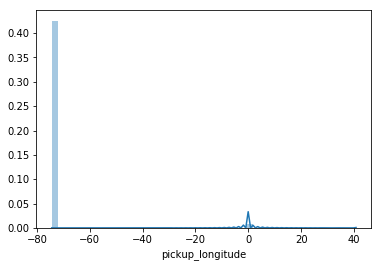

In [26]:
sns.distplot(cab_df['pickup_longitude'],kde=True)

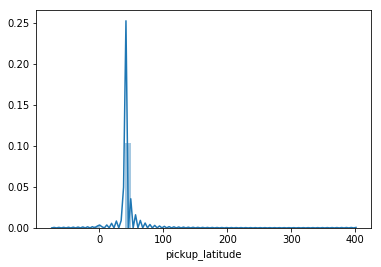

In [27]:
sns.distplot(cab_df['pickup_latitude'],kde=True)

In [28]:
cab_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16041.000000,16041.000000,16041.000000,16041.000000,16041.000000,16041.000000
mean,15.015223,-72.469552,39.918441,-72.469112,39.901596,2.619246
std,430.474362,10.555823,6.817485,10.552491,6.175961,60.787707
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992157,40.734935,-73.991182,40.734663,1.000000
50%,8.500000,-73.981704,40.752600,-73.980182,40.753564,1.000000
75%,12.500000,-73.966842,40.767353,-73.963646,40.768005,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In [29]:
'''There are few strange values in the data like :
minimum fare_amount is -3, fare can never be negative.
pickup_latitude max value is out of range.
minimum passenger_count is 0 which can't be the case.
So to clean these values we detect and remove the outliers from our data.'''

"There are few strange values in the data like :\nminimum fare_amount is -3, fare can never be negative.\npickup_latitude max value is out of range.\nminimum passenger_count is 0 which can't be the case.\nSo to clean these values we detect and remove the outliers from our data."

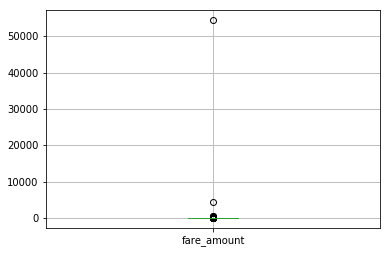

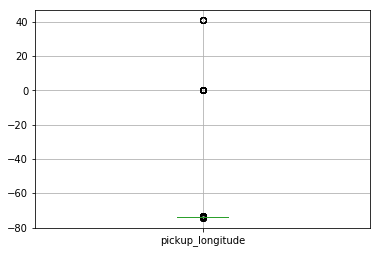

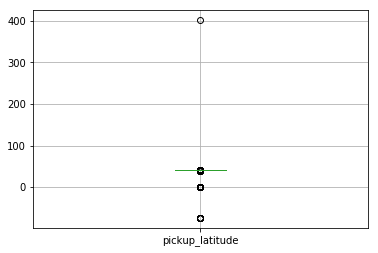

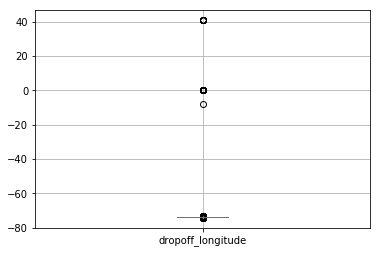

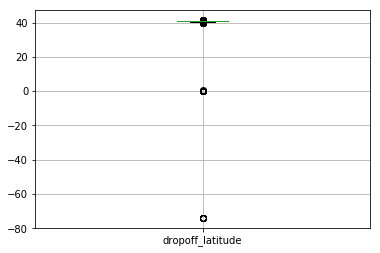

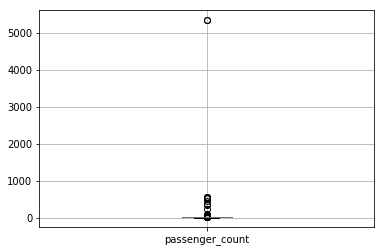

In [30]:
num_variables=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count']
for i in num_variables:
    cab_df.boxplot(column=i)
    plt.show()

In [33]:
for i in num_variables:
    q75,q25=np.percentile(cab_df.loc[:,i],[75,25])
    iqr=q75-q25
    min=q25 -(1.5*iqr)
    max=q75 +(1.5*iqr)
    
    cab_df=cab_df.drop(cab_df[cab_df.loc[:,i]<min].index)
    cab_df=cab_df.drop(cab_df[cab_df.loc[:,i]>max].index)

In [34]:
#Latitude : 40.730610, Longitude : -73.935242
cab_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,11858.000000,11858.000000,11858.000000,11858.000000,11858.000000,11858.000000
mean,8.558147,-73.981889,40.752934,-73.981032,40.753352,1.250414
std,3.819701,0.016008,0.021033,0.016496,0.021875,0.539359
min,-2.500000,-74.018108,40.693504,-74.019535,40.694260,0.000000
25%,5.700000,-73.992844,40.738600,-73.992087,40.738852,1.000000
50%,7.700000,-73.982749,40.753499,-73.982093,40.754577,1.000000
75%,10.500000,-73.971549,40.766756,-73.970887,40.767361,1.000000
max,22.100000,-73.932999,40.810862,-73.935413,40.811382,3.471640


In [35]:
cab_df = cab_df[(cab_df['passenger_count']>= 1)]
cab_df = cab_df[(cab_df['fare_amount']>=1)]
cab_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,11792.000000,11792.000000,11792.000000,11792.000000,11792.000000,11792.000000
mean,8.562101,-73.981885,40.752947,-73.981039,40.753360,1.256130
std,3.818234,0.016012,0.021023,0.016487,0.021879,0.534496
min,2.500000,-74.018108,40.693504,-74.019535,40.694260,1.000000
25%,5.700000,-73.992834,40.738610,-73.992078,40.738892,1.000000
50%,7.700000,-73.982749,40.753507,-73.982093,40.754554,1.000000
75%,10.500000,-73.971547,40.766758,-73.970896,40.767344,1.000000
max,22.100000,-73.932999,40.810862,-73.935413,40.811382,3.471640


In [36]:
cab_df['passenger_count'] = round(cab_df['passenger_count'])
cab_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,11792.000000,11792.000000,11792.000000,11792.000000,11792.000000,11792.000000
mean,8.562101,-73.981885,40.752947,-73.981039,40.753360,1.256021
std,3.818234,0.016012,0.021023,0.016487,0.021879,0.534619
min,2.500000,-74.018108,40.693504,-74.019535,40.694260,1.000000
25%,5.700000,-73.992834,40.738610,-73.992078,40.738892,1.000000
50%,7.700000,-73.982749,40.753507,-73.982093,40.754554,1.000000
75%,10.500000,-73.971547,40.766758,-73.970896,40.767344,1.000000
max,22.100000,-73.932999,40.810862,-73.935413,40.811382,3.000000


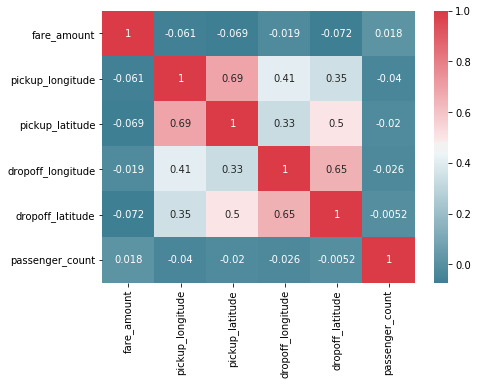

In [37]:
f, ax=plt.subplots(figsize=(7,5))

sns.heatmap(cab_df.corr(),mask=np.zeros_like(cab_df.corr(),dtype=np.bool),
           cmap=sns.diverging_palette(220,10,as_cmap=True),ax=ax,annot = True)

In [38]:
#Feature Engineering : Now after missing value and outlier analysis, we extract some new features from existing ones, which
#can help further in analysis.

In [39]:
cab_df['year'] = cab_df.pickup_datetime.dt.year
cab_df['month'] = cab_df.pickup_datetime.dt.month
cab_df['day'] = cab_df.pickup_datetime.dt.day
cab_df['weekday'] = cab_df.pickup_datetime.dt.weekday
cab_df['hour'] = cab_df.pickup_datetime.dt.hour

In [40]:
del cab_df['pickup_datetime']

In [41]:
def haversine_distance(lat1, long1, lat2, long2):
    data = [cab_df]
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['distance_km'] = d
    return d

In [42]:
cab_df['distance_km'] = haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
cab_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour,distance_km
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,1,16,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,3,0,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,5,4,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,1,7,1.999157
5,12.1,-74.000964,40.731630,-73.972892,40.758233,1.0,2011,1,6,3,9,3.787239


In [43]:
del cab_df['pickup_longitude']
del cab_df['pickup_latitude']
del cab_df['dropoff_longitude']
del cab_df['dropoff_latitude']
cab_df.head()

,fare_amount,passenger_count,year,month,day,weekday,hour,distance_km
1,16.9,1.0,2010,1,5,1,16,8.450134
2,5.7,2.0,2011,8,18,3,0,1.389525
3,7.7,1.0,2012,4,21,5,4,2.799270
4,5.3,1.0,2010,3,9,1,7,1.999157
5,12.1,1.0,2011,1,6,3,9,3.787239


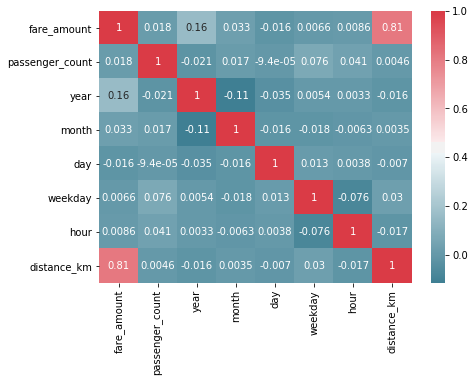

In [44]:
f, ax=plt.subplots(figsize=(7,5))

sns.heatmap(cab_df.corr(),mask=np.zeros_like(cab_df.corr(),dtype=np.bool),
           cmap=sns.diverging_palette(220,10,as_cmap=True),ax=ax,annot=True)

In [45]:
#Exploratory Data Analysis : to understand the data and make some inferences out of it.

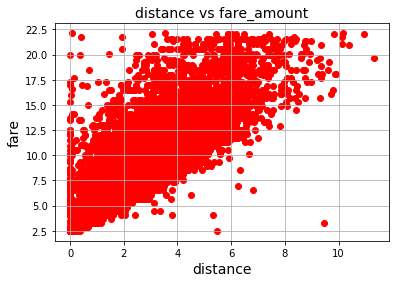

In [46]:
#Shows the distribution b/w distance and fare
plt.scatter(cab_df['distance_km'], cab_df['fare_amount'], color='red')

plt.title('distance vs fare_amount', fontsize=14)

plt.xlabel('distance', fontsize=14)

plt.ylabel('fare', fontsize=14)

plt.grid(True)

plt.show()

Text(0, 0.5, 'Fare')

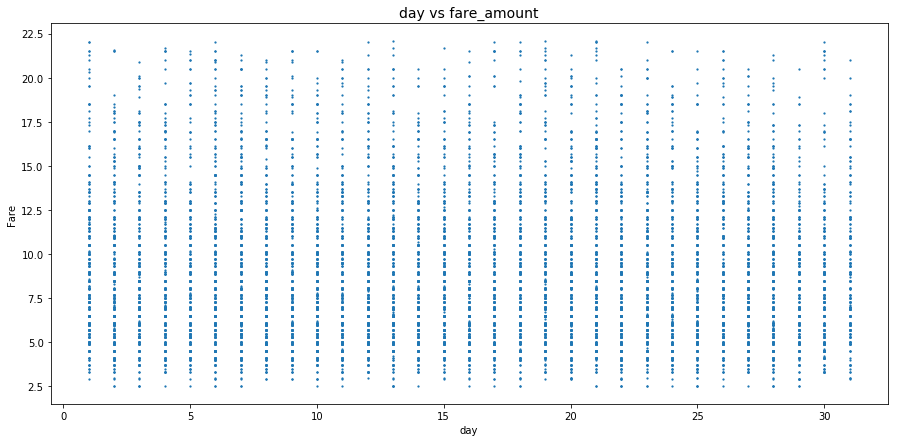

In [47]:
#shows how the different days have different fare amount
plt.figure(figsize=(15,7))
plt.scatter(x=cab_df['day'], y=cab_df['fare_amount'], s=1.5)
plt.title('day vs fare_amount', fontsize=14)
plt.xlabel('day')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

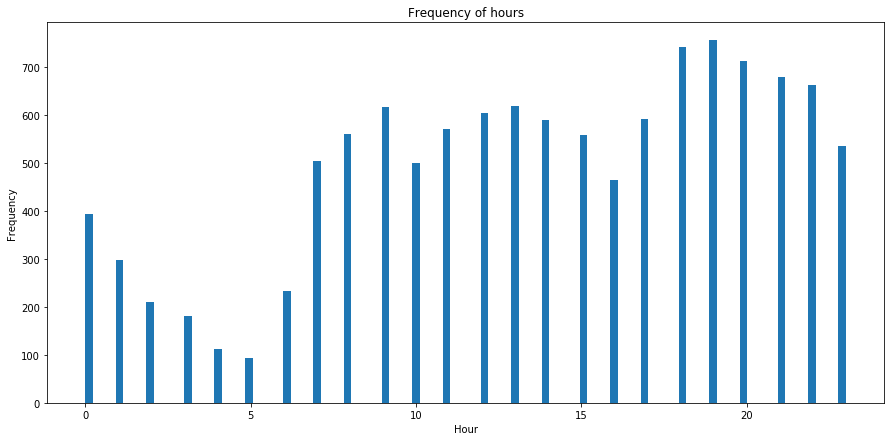

In [48]:
#shows the frequency of hours, (tells us about the most active hour)
plt.figure(figsize=(15,7))
plt.hist(cab_df['hour'], bins=100)
plt.title('Frequency of hours')
plt.xlabel('Hour')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

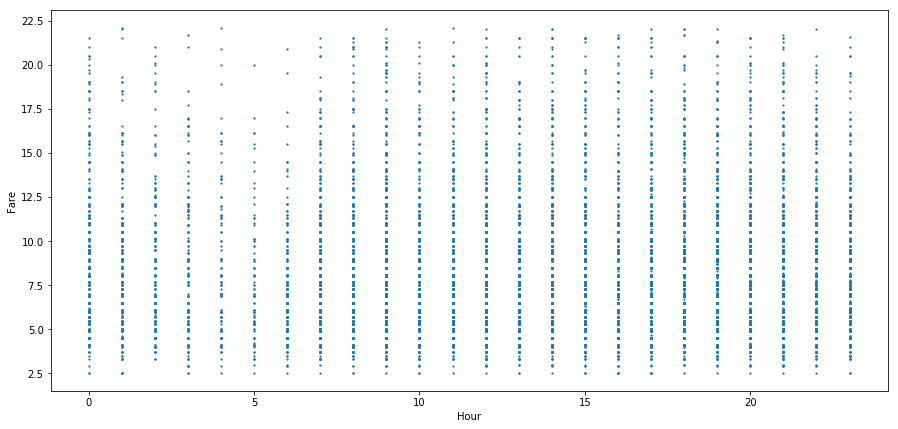

In [49]:
#Hour vs Fare_amount
plt.figure(figsize=(15,7))
plt.scatter(x=cab_df['hour'], y=cab_df['fare_amount'], s=1.5)
plt.xlabel('Hour')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

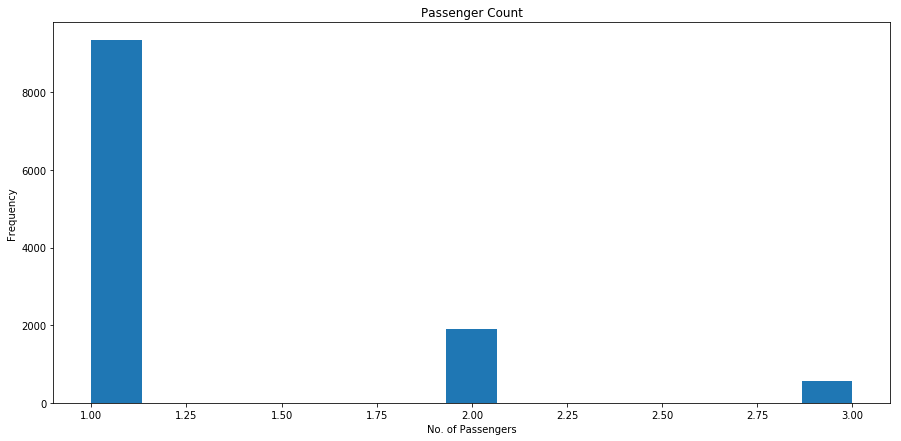

In [50]:
#shows the frequency of number of passengers
plt.figure(figsize=(15,7))
plt.hist(cab_df['passenger_count'], bins=15)
plt.title('Passenger Count')
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

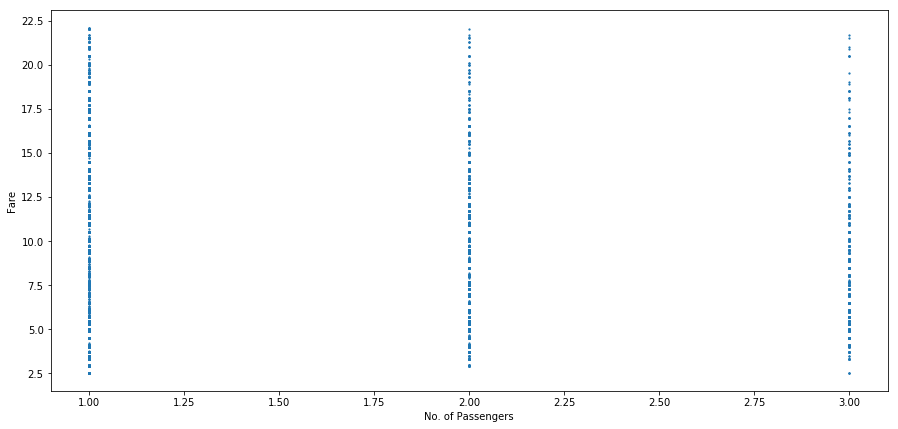

In [51]:
#Number of Passengers vs Fare_amount
plt.figure(figsize=(15,7))
plt.scatter(x=cab_df['passenger_count'], y=cab_df['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

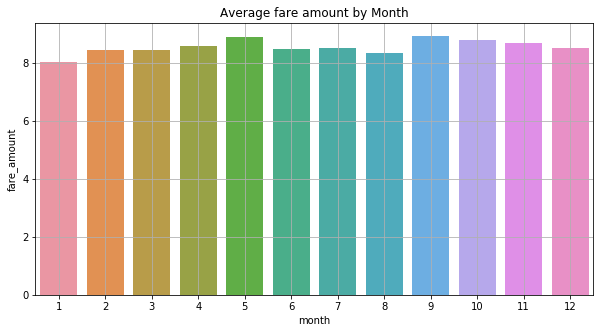

In [52]:
#Shows the average fare_amount by Month
fare_mn = cab_df.groupby("month")["fare_amount"].mean().reset_index()
plt.figure(figsize = (10,5))
sns.barplot("month","fare_amount",
            data = fare_mn,
            linewidth =1)
plt.grid(True)
plt.title("Average fare amount by Month")
plt.show()

In [53]:
cab_df['year'].unique()

array([2010, 2011, 2012, 2009, 2013, 2014, 2015], dtype=int64)

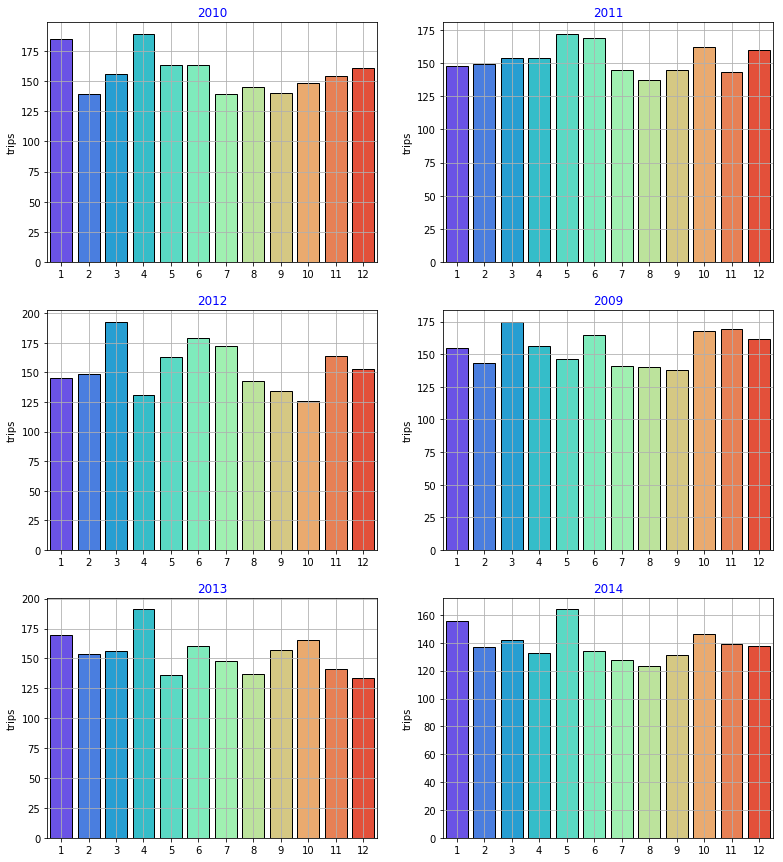

In [54]:
#shows the trends of trips every month of all years except for 2015 as it doesn't have data for all months

yrs = [i for i in cab_df["year"].unique().tolist() if i not in [2015]]

#subset data without year 2015
complete_dat = cab_df[cab_df["year"].isin(yrs)]


plt.figure(figsize = (13,15))
for i,j in itertools.zip_longest(yrs,range(len(yrs))) :
    plt.subplot(3,2,j+1)
    trip_counts_mn = complete_dat[complete_dat["year"] == i]["month"].value_counts()
    trip_counts_mn = trip_counts_mn.reset_index()
    sns.barplot(trip_counts_mn["index"],trip_counts_mn["month"],
                palette = "rainbow",linewidth = 1,
                edgecolor = "k"*complete_dat["month"].nunique() 
               )
    plt.title(i,color = "b",fontsize = 12)
    plt.grid(True)
    plt.xlabel("")
    plt.ylabel("trips")

In [55]:
#Train_test Splitting : Simple Random Sampling as we are dealing with continuous variables
X = cab_df.iloc[:,1:].values
Y = cab_df.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state = 0)

In [56]:
#Multiple Linear Regression
model = sm.OLS(y_train,X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 2.235e+04
Date:                Thu, 04 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:52:58   Log-Likelihood:                -20983.
No. Observations:                9433   AIC:                         4.198e+04
Df Residuals:                    9426   BIC:                         4.203e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0810      0.043      1.886      0.059      -0.003       0.165
x2             0.0018   5.35e-05     34.380      0.000       0.002       0.002
x3             0.0321      0.007      4.812      0.000       0.019       0.045
x4            -0.0044      0.003     -1.672      0.095      -0.010       0.001
x5            -0.0307      0.012     -2.585      0.010      -0.054      -0.007
x6             0.0117      0.004      3.203      0.001       0.005       0.019
x7             1.9740      0.015    134.885      0.000       1.945       2.003
==============================================================================
Omnibus:                     2940.232   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14475.092
Skew:                           1.427   Prob(JB):                         0.00
Kurtosis:                       8.355   Cond. No.                     3.75e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
predictions_LR = model.predict(X_test)

In [61]:
error = sqrt(metrics.mean_squared_error(y_test,predictions_LR)) #calculate rmse
print('RMSE value for Multiple Linear Regression is:', error)

RMSE value for Multiple Linear Regression is: 2.161418831852699


In [62]:
#Decision Tree
train,test = train_test_split(cab_df,test_size = 0.2,random_state=0)
fit = DecisionTreeRegressor(max_depth=5).fit(train.iloc[:,1:],train.iloc[:,0])
predictions_DT = fit.predict(test.iloc[:,1:])
predictions_DT

array([ 4.90754573,  7.65791667,  6.87668161, ..., 10.03389831,
       11.94214559,  4.90754573])

In [63]:
error = sqrt(metrics.mean_squared_error(y_test,predictions_DT)) #calculate rmse
print('R square value for Decision Tree is: ',metrics.r2_score(y_test,predictions_DT))
print('RMSE value for Decision Tree is:', error)

R square value for Decision Tree is:  0.6965263235742822
RMSE value for Decision Tree is: 2.066720962852115


In [64]:
#Random Forest
X = cab_df.iloc[:,1:].values
Y = cab_df.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test) 

In [65]:
regressor = RandomForestRegressor(n_estimators=200, random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)  
y_pred
print('R square value for Random Forest is: ',metrics.r2_score(y_test,y_pred))
print('RMSE value for Random Forest is :', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

R square value for Random Forest is:  0.7027788219359306
RMSE value for Random Forest is : 2.0453197273408374


In [66]:
#K Nearest Neighbours
train , test = train_test_split(cab_df, test_size = 0.2)

x_train = train.drop('fare_amount', axis=1)
y_train = train['fare_amount']

x_test = test.drop('fare_amount', axis = 1)
y_test = test['fare_amount']

In [67]:
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

In [68]:
#import required packages
get_ipython()

In [69]:
model = neighbors.KNeighborsRegressor(n_neighbors = 10)
model.fit(x_train, y_train)  #fit the model
pred=model.predict(x_test) #make prediction on test set
error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse

print('R square value for K Nearest Neighbours is: ',metrics.r2_score(y_test,pred))
print('RMSE value for K Nearest Neighbours is:', error)

R square value for K Nearest Neighbours is:  0.60422658375304
RMSE value for K Nearest Neighbours is: 2.431476345415033


In [70]:
'''
Error metric used is Root Mean Square Error as this is a Time Series Forecasting Problem. 
It represents the sample standard deviation of the differences between predicted values and observed values (called residuals).
Lower RMSE mean better model performance.
RMSE -->
MLR : 2.16
DT : 2.06
RF : 2.04
KNN : 2.43

Best Linear Regression as highest r2 = 94.3
'''
print('Highest accuracy : 94.3 --> Linear Regression, so using this model to predict')

Highest accuracy : 94.3 --> Linear Regression, so using this model to predict


In [71]:
#Now that we have chosen the right model, we use it to predict fare_Amount for our test cases.
#For that we first preprocess the test dataset and make it appropriate in such a way that it fits the model i.e the 
#input variables be same as the input variables of the algorithm chosen.

In [72]:
test_df = pd.read_csv('test.csv')
print(test_df.describe())

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count       9914.000000      9914.000000        9914.000000       9914.000000   
mean         -73.974722        40.751041         -73.973657         40.751743   
std            0.042774         0.033541           0.039072          0.035435   
min          -74.252193        40.573143         -74.263242         40.568973   
25%          -73.992501        40.736125         -73.991247         40.735254   
50%          -73.982326        40.753051         -73.980015         40.754065   
75%          -73.968013        40.767113         -73.964059         40.768757   
max          -72.986532        41.709555         -72.990963         41.696683   

       passenger_count  
count      9914.000000  
mean          1.671273  
std           1.278747  
min           1.000000  
25%           1.000000  
50%           1.000000  
75%           2.000000  
max           6.000000  


In [73]:
#Check missing value
print(test_df.isnull().sum())

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [74]:
#Data type conversion
test_df['pickup_datetime']=pd.to_datetime(test_df['pickup_datetime'])
print(test_df.dtypes)

pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object


In [75]:
#Outlier Analysis
num_variables=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count']
for i in num_variables:
    q75,q25=np.percentile(test_df.loc[:,i],[75,25])
    iqr=q75-q25
    min=q25 -(1.5*iqr)
    max=q75 +(1.5*iqr)
    
    test_df=test_df.drop(test_df[test_df.loc[:,i]<min].index)
    test_df=test_df.drop(test_df[test_df.loc[:,i]>max].index)

In [76]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,7687.000000,7687.000000,7687.000000,7687.000000,7687.000000
mean,-73.981871,40.752475,-73.980279,40.753094,1.266944
std,0.016354,0.021372,0.017423,0.023315,0.544916
min,-74.023050,40.692392,-74.028842,40.688838,1.000000
25%,-73.993313,40.737385,-73.992014,40.737626,1.000000
50%,-73.983221,40.753280,-73.981340,40.754463,1.000000
75%,-73.970814,40.766678,-73.969173,40.768384,1.000000
max,-73.931783,40.810477,-73.927247,40.816254,3.000000


In [77]:
#Feature Engineering
test_df['year'] = test_df.pickup_datetime.dt.year
test_df['month'] = test_df.pickup_datetime.dt.month
test_df['day'] = test_df.pickup_datetime.dt.day
test_df['weekday'] = test_df.pickup_datetime.dt.weekday
test_df['hour'] = test_df.pickup_datetime.dt.hour
del test_df['pickup_datetime']

In [78]:
def haversine_distance(lat1, long1, lat2, long2):
    data = [test_df]
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['distance_km'] = d
    return d

In [79]:
test_df['distance_km'] = haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
test_df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour,distance_km
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,2.323259
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,2.425353
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,5,11,0.618628
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,5,21,1.961033
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,5,21,5.387301


In [80]:
del test_df['pickup_longitude']
del test_df['pickup_latitude']
del test_df['dropoff_longitude']
del test_df['dropoff_latitude']
test_df.describe()

,passenger_count,year,month,day,weekday,hour,distance_km
count,7687.000000,7687.000000,7687.000000,7687.000000,7687.000000,7687.000000,7687.000000
mean,1.266944,2011.809158,6.782100,16.026278,2.852218,13.586965,2.464695
std,0.544916,1.807156,3.376535,8.860358,1.982952,6.670019,1.731423
min,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,2010.000000,4.000000,9.000000,1.000000,8.000000,1.216531
50%,1.000000,2012.000000,7.000000,16.000000,3.000000,14.000000,1.997451
75%,1.000000,2013.000000,10.000000,24.000000,5.000000,19.000000,3.240176
max,3.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,12.150068


In [81]:
#Feature scaling for all values to lie under 1 range and then predicting
y = sc.transform(test_df) 
predicted_fare = model.predict(y)
predicted_fare

array([ 7.85,  7.85,  4.94, ..., 12.02,  5.39,  8.68])

In [82]:
test_df['predicted_fare'] = predicted_fare

In [83]:
test_df.head()

,passenger_count,year,month,day,weekday,hour,distance_km,predicted_fare
0,1,2015,1,27,1,13,2.323259,7.85
1,1,2015,1,27,1,13,2.425353,7.85
2,1,2011,10,8,5,11,0.618628,4.94
3,1,2012,12,1,5,21,1.961033,6.71
4,1,2012,12,1,5,21,5.387301,16.32


In [84]:
test_df = test_df[test_df['distance_km']>=1]
test_df.describe()

,passenger_count,year,month,day,weekday,hour,distance_km,predicted_fare
count,6396.000000,6396.000000,6396.00000,6396.000000,6396.000000,6396.000000,6396.000000,6396.000000
mean,1.267511,2011.811914,6.82192,16.015322,2.854597,13.632739,2.828423,9.086448
std,0.545260,1.801777,3.36226,8.865113,1.984647,6.723912,1.673641,3.862225
min,1.000000,2009.000000,1.00000,1.000000,0.000000,0.000000,1.000068,3.940000
25%,1.000000,2010.000000,4.00000,9.000000,1.000000,8.000000,1.581117,6.260000
50%,1.000000,2012.000000,7.00000,16.000000,3.000000,15.000000,2.330298,7.550000
75%,1.000000,2013.000000,10.00000,24.000000,5.000000,19.000000,3.595257,11.000000
max,3.000000,2015.000000,12.00000,31.000000,6.000000,23.000000,12.150068,20.490000


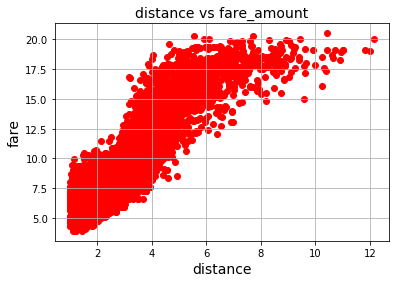

In [85]:
plt.scatter(test_df['distance_km'], test_df['predicted_fare'], color='red')

plt.title('distance vs fare_amount', fontsize=14)

plt.xlabel('distance', fontsize=14)

plt.ylabel('fare', fontsize=14)

plt.grid(True)

plt.show()

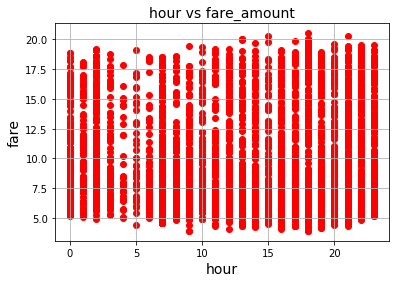

In [86]:
plt.scatter(test_df['hour'],test_df['predicted_fare'], color='red')

plt.title('hour vs fare_amount', fontsize=14)

plt.xlabel('hour', fontsize=14)

plt.ylabel('fare', fontsize=14)

plt.grid(True)

plt.show()

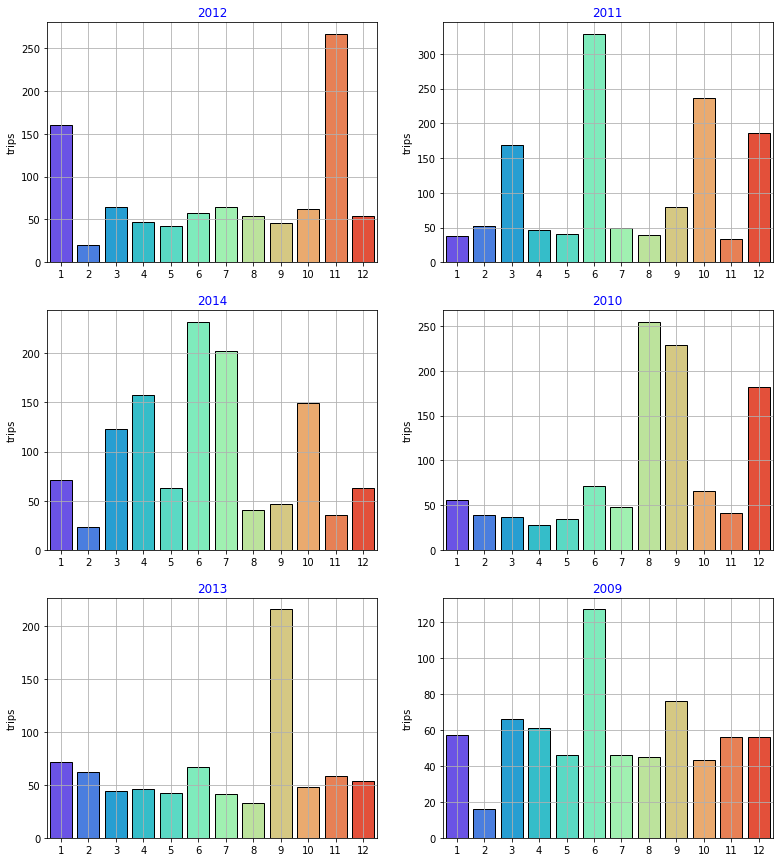

In [87]:
import itertools
yrs = [i for i in test_df["year"].unique().tolist() if i not in [2015]]

#subset data without year 2015
complete_dat = test_df[test_df["year"].isin(yrs)]


plt.figure(figsize = (13,15))
for i,j in itertools.zip_longest(yrs,range(len(yrs))) :
    plt.subplot(3,2,j+1)
    trip_counts_mn = complete_dat[complete_dat["year"] == i]["month"].value_counts()
    trip_counts_mn = trip_counts_mn.reset_index()
    sns.barplot(trip_counts_mn["index"],trip_counts_mn["month"],
                palette = "rainbow",linewidth = 1,
                edgecolor = "k"*complete_dat["month"].nunique() 
               )
    plt.title(i,color = "b",fontsize = 12)
    plt.grid(True)
    plt.xlabel("")
    plt.ylabel("trips")

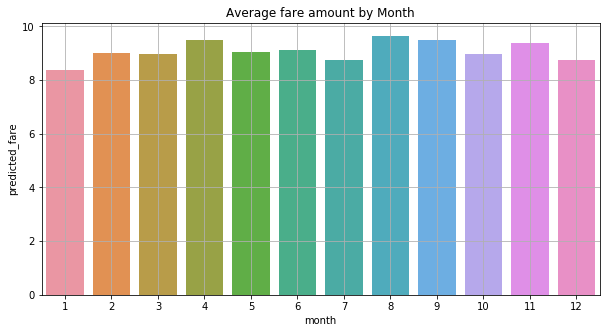

In [88]:
fare_mn = test_df.groupby("month")["predicted_fare"].mean().reset_index()


plt.figure(figsize = (10,5))
sns.barplot("month","predicted_fare",
            data = fare_mn,
            linewidth =1)
plt.grid(True)
plt.title("Average fare amount by Month")
plt.show()

In [89]:
import pickle

In [90]:
pickle.dump(model, open("predict_fare.pkl","wb"))